In [1]:
#!pip install mne
#!pip install tensorflow
#!pip install keras
#!pip install scikit-learn



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [41]:
# Part 1: Importing necessary libraries
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
import os

# 1. Load the EEG data
data_dir = os.path.expanduser("~/Downloads/physionet.org/files/eegmat/1.0.0/")

def load_edf_files(directory):
    raw_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".edf"):
            file_path = os.path.join(directory, filename)
            raw = mne.io.read_raw_edf(file_path, preload=True)
            raw_list.append(raw)
    return raw_list

raw_list = load_edf_files(data_dir)
print(f"Loaded {len(raw_list)} EDF files")

# Combine all raw objects
raw_combined = mne.concatenate_raws(raw_list)
print(raw_combined.info)

Extracting EDF parameters from /Users/samyakjain/Downloads/physionet.org/files/eegmat/1.0.0/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/samyakjain/Downloads/physionet.org/files/eegmat/1.0.0/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/samyakjain/Downloads/physionet.org/files/eegmat/1.0.0/Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...
Extracting EDF parameters from /Users/samyakjain/Downloads/physionet.org/files/eegmat/1.0.0/Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


Effective window size : 4.096 (s)


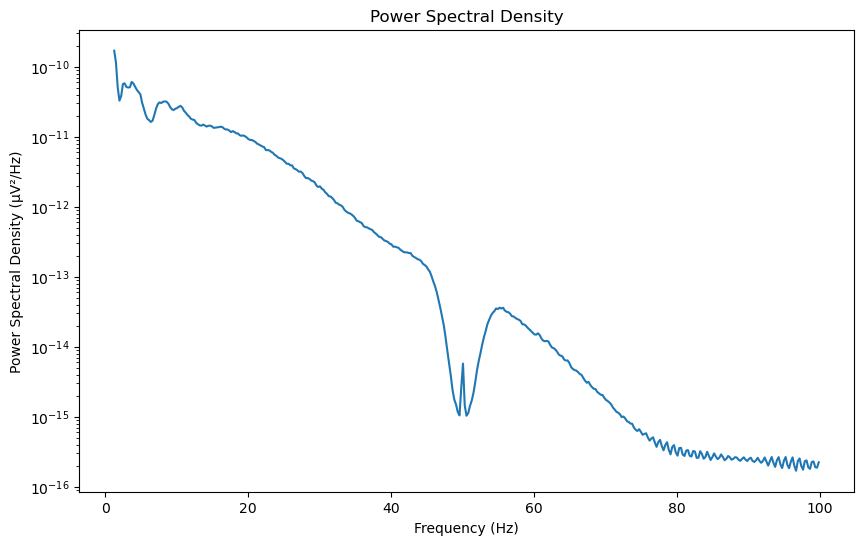

In [42]:
# 2. Power Spectral Density (PSD) Analysis
fmin, fmax = 1, 100
n_fft = 2048  # Adjust this value based on your needs

# Get the data from raw_combined
data = raw_combined.get_data()
sfreq = raw_combined.info['sfreq']

# Compute PSD
psds, freqs = psd_array_welch(data, sfreq, fmin=fmin, fmax=fmax, n_fft=n_fft)

bands = {'Delta': (1, 4),
         'Theta': (4, 8),
         'Alpha': (8, 12),
         'Beta': (12, 30),
         'Gamma': (30, 100)}

band_powers = {}
for band, (fmin, fmax) in bands.items():
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    psds_band = psds[:, freq_mask].mean(axis=1)
    band_powers[band] = psds_band

# Visualize PSD
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, psds.mean(axis=0))
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.show()


In [43]:
def extract_features(raw_combined, segment_duration=1.0):
    data = raw_combined.get_data()
    sfreq = raw_combined.info['sfreq']
    n_channels, n_times = data.shape
    
    segment_samples = int(segment_duration * sfreq)
    n_segments = n_times // segment_samples
    
    features = []
    for i in range(n_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = data[:, start:end]
        features.append(segment)
    
    features = np.array(features)
    
    # Assuming first half is rest, second half is task
    n_samples = features.shape[0]
    labels = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    return features, labels

# Extract features
features, labels = extract_features(raw_combined)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
# Reshape the data to (batch_size, channels, height, width)

# Print shapes
print("Shape of features:", features.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of features: (8676, 21, 500)
Shape of X_train: torch.Size([6940, 21, 500])
Shape of y_train: torch.Size([6940])


In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# Define the EEGNet model class
class EEGNet(nn.Module):
    def __init__(self, num_channels, num_samples, num_classes):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        self.depthwise_conv = nn.Conv2d(16, 32, (num_channels, 1), stride=(1, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, False)
        self.fc1 = nn.Linear(32 * num_samples, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.depthwise_conv(x)
        x = F.relu(self.batchnorm2(x))
        x = x.view(x.size(0), -1)  # Flattening the layer
        x = self.fc1(x)
        return x

# Define the TSCeption model class
class TSCeption(nn.Module):
    def __init__(self, num_classes=2, in_channels=1, num_T=9, num_S=6, sample_length=5):
        super(TSCeption, self).__init__()
        self.in_channels = in_channels
        self.num_T = num_T
        self.num_S = num_S
        self.sample_length = sample_length
        
        self.Tception1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, (1, 3), stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.Tception2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, (1, 5), stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        
        self.Sception1 = nn.Sequential(
            nn.Conv2d(16, 32, (3, 1), stride=1, padding=0, groups=16),
            nn.BatchNorm2d(32),
            nn.ELU()
        )
        self.Sception2 = nn.Sequential(
            nn.Conv2d(16, 32, (5, 1), stride=1, padding=0, groups=16),
            nn.BatchNorm2d(32),
            nn.ELU()
        )
        
        self.fc = nn.Linear(32 * (sample_length - 4), num_classes)

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=1)
        y = self.Sception1(out)
        out = y
        y = self.Sception2(out)
        out = torch.cat((out, y), dim=1)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Example of a simple training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.2f}%')
    return model

# Example of a simple evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [45]:
# Part 8: Preparing DataLoader for training
batch_size = 32

# Ensure X_train and X_test are PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.long).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.long).clone().detach()

# Reshape data to the expected dimensions [batch_size, 1, num_channels, num_samples]
X_train = X_train.unsqueeze(1)  # Add a channel dimension
X_test = X_test.unsqueeze(1)  # Add a channel dimension

# Print the shape of X_train and X_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Creating DataLoader for training and testing data
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get the input shape for the model
in_channels, num_channels, num_samples = X_train.shape[1], X_train.shape[2], X_train.shape[3]

# Part 9: Train and evaluate EEGNet
eegnet = EEGNet(num_channels=num_channels, num_samples=num_samples, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eegnet.parameters())

eegnet = train_model(eegnet, train_loader, test_loader, criterion, optimizer, num_epochs=100)
print("EEGNet Evaluation:")
evaluate_model(eegnet, test_loader)

/var/folders/7w/tfyt6rt124n73xvzq62ryd7m0000gn/T/ipykernel_15027/112907356.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
/var/folders/7w/tfyt6rt124n73xvzq62ryd7m0000gn/T/ipykernel_15027/112907356.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).clone().detach()
/var/folders/7w/tfyt6rt124n73xvzq62ryd7m0000gn/T/ipykernel_15027/112907356.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_te

Shape of X_train: torch.Size([6940, 1, 21, 500])
Shape of X_test: torch.Size([1736, 1, 21, 500])
Epoch 1/100, Accuracy: 59.85%
Epoch 2/100, Accuracy: 60.43%
Epoch 3/100, Accuracy: 67.22%
Epoch 4/100, Accuracy: 76.44%
Epoch 5/100, Accuracy: 76.56%
Epoch 6/100, Accuracy: 78.51%
Epoch 7/100, Accuracy: 80.24%
Epoch 8/100, Accuracy: 77.07%
Epoch 9/100, Accuracy: 83.53%
Epoch 10/100, Accuracy: 82.26%
Epoch 11/100, Accuracy: 86.23%
Epoch 12/100, Accuracy: 85.14%
Epoch 13/100, Accuracy: 85.20%
Epoch 14/100, Accuracy: 84.62%
Epoch 15/100, Accuracy: 81.97%
Epoch 16/100, Accuracy: 83.06%
Epoch 17/100, Accuracy: 85.89%
Epoch 18/100, Accuracy: 86.52%
Epoch 19/100, Accuracy: 83.70%
Epoch 20/100, Accuracy: 83.41%
Epoch 21/100, Accuracy: 85.20%
Epoch 22/100, Accuracy: 85.25%
Epoch 23/100, Accuracy: 85.37%
Epoch 24/100, Accuracy: 77.59%
Epoch 25/100, Accuracy: 85.77%
Epoch 26/100, Accuracy: 82.95%
Epoch 27/100, Accuracy: 85.71%
Epoch 28/100, Accuracy: 85.94%
Epoch 29/100, Accuracy: 85.08%
Epoch 30/100,

In [46]:
class TSCeption(nn.Module):
    def __init__(self, num_classes=2, in_channels=1, num_T=9, num_S=6, num_channels=22, sample_length=500):
        super(TSCeption, self).__init__()
        self.in_channels = in_channels
        self.num_T = num_T
        self.num_S = num_S
        self.num_channels = num_channels
        self.sample_length = sample_length
        
        self.Tception1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, (1, 3), stride=1, padding=(0, 1)),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.Tception2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, (1, 5), stride=1, padding=(0, 2)),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        
        self.Sception1 = nn.Sequential(
            nn.Conv2d(32, 32, (3, 1), stride=1, padding=(1, 0), groups=32),
            nn.BatchNorm2d(32),
            nn.ELU()
        )
        self.Sception2 = nn.Sequential(
            nn.Conv2d(32, 32, (5, 1), stride=1, padding=(2, 0), groups=32),
            nn.BatchNorm2d(32),
            nn.ELU()
        )
        
        # Calculate the size of the flattened features
        self.flatten_size = 64 * num_channels * sample_length
        
        self.fc = nn.Linear(self.flatten_size, num_classes)

    def forward(self, x):
        y1 = self.Tception1(x)
        y2 = self.Tception2(x)
        out = torch.cat((y1, y2), dim=1)
        
        y1 = self.Sception1(out)
        y2 = self.Sception2(out)
        out = torch.cat((y1, y2), dim=1)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [47]:
# Part 10: Train and evaluate TSCeption
num_channels = X_train.shape[2]  # Assuming X_train shape is [batch, 1, channels, samples]
sample_length = X_train.shape[3]

tsception = TSCeption(num_classes=2, in_channels=1, num_T=9, num_S=6, 
                      num_channels=num_channels, sample_length=sample_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tsception.parameters())

tsception = train_model(tsception, train_loader, test_loader, criterion, optimizer, num_epochs=100)
print("TSCeption Evaluation:")
evaluate_model(tsception, test_loader)


Epoch 1/100, Accuracy: 49.88%
Epoch 2/100, Accuracy: 50.12%
Epoch 3/100, Accuracy: 49.88%
Epoch 4/100, Accuracy: 49.88%
Epoch 5/100, Accuracy: 49.88%
Epoch 6/100, Accuracy: 49.88%
Epoch 7/100, Accuracy: 49.88%
Epoch 8/100, Accuracy: 50.12%
Epoch 9/100, Accuracy: 49.88%
Epoch 10/100, Accuracy: 49.88%
Epoch 11/100, Accuracy: 50.12%
Epoch 12/100, Accuracy: 50.12%
Epoch 13/100, Accuracy: 50.12%
Epoch 14/100, Accuracy: 49.88%
Epoch 15/100, Accuracy: 50.12%
Epoch 16/100, Accuracy: 50.12%
Epoch 17/100, Accuracy: 49.88%
Epoch 18/100, Accuracy: 50.12%
Epoch 19/100, Accuracy: 49.88%
Epoch 20/100, Accuracy: 50.12%
Epoch 21/100, Accuracy: 49.88%
Epoch 22/100, Accuracy: 50.12%
Epoch 23/100, Accuracy: 49.88%
Epoch 24/100, Accuracy: 49.88%
Epoch 25/100, Accuracy: 49.88%
Epoch 26/100, Accuracy: 50.12%
Epoch 27/100, Accuracy: 50.12%
Epoch 28/100, Accuracy: 49.88%
Epoch 29/100, Accuracy: 49.88%
Epoch 30/100, Accuracy: 49.88%
Epoch 31/100, Accuracy: 50.12%
Epoch 32/100, Accuracy: 50.12%
Epoch 33/100, Acc

KeyboardInterrupt: 